# Preprocessing of 2 photon imaging(All In One)
## Feature:
- Ubuntu system
- Hsa fish line
- Multi-plane imaging(ETL)
- Batch processing for all the fish in one folder

## Software needed:
- ANTs
- Fiji
- suite2p

## Input of the code:
- zstack
- experimental imaging volume(ETL version)
- reference atlas zstack for registration

## Objective
- Finish the batch processing of all nd2 files to tif files, multi-plane experimental volume will be divided into single plane
- Finish the motion correction and segmentation of experimental imaging video of each planes by suite2p
- Finish the 2d registration(including prepare the 2d reference by template matching) and 3d registration
- Apply registration files onto the segmented ROI coordinates


In [38]:
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
from nd2reader import ND2Reader
import tifffile
import glob
import bg_space as bg
import pandas as pd
import time

In [6]:
def nd2_to_tif(nd2_file, raw_tif_file):
    with ND2Reader(nd2_file) as imaging_series:
        umperpix = imaging_series.metadata['pixel_microns']
        imaging_series_arr = np.array([i for i in imaging_series])
        imaging_series_8bit_arr = cv2.convertScaleAbs(imaging_series_arr, alpha=0.07)
        imaging_series_mapped_arr = bg.map_stack_to('ilp','ial', imaging_series_8bit_arr) ##refer to bg-space AnatomicalSpace
        tifffile.imwrite(raw_tif_file, imaging_series_mapped_arr, imagej=True, resolution=(1/umperpix, 1/umperpix), metadata = imaging_series.metadata)
#         tifffile.imwrite(raw_tif_file, imaging_series_mapped_arr, imagej=True)


def nd2_to_tif_zscan(nd2_file, raw_tif_file):

    with ND2Reader(nd2_file) as imaging_series:
        umperpix = imaging_series.metadata['pixel_microns']
        imaging_series_arr = np.array([i for i in imaging_series])
        imaging_series_8bit_arr = cv2.convertScaleAbs(imaging_series_arr, alpha=0.07)
        imaging_series_mapped_arr = bg.map_stack_to('ilp','sal', imaging_series_8bit_arr) ##refer to bg-space AnatomicalSpace
        tifffile.imwrite(raw_tif_file, imaging_series_mapped_arr, imagej=True, resolution=(1/umperpix, 1/umperpix), metadata = imaging_series.metadata)
#         tifffile.imwrite(raw_tif_file, imaging_series_mapped_arr, imagej=True)


def tif_concat(raw_tif_file_list, combined_tif_path):

    combined_tif = []
    for raw_tif in raw_tif_file_list:
        im = tifffile.imread(raw_tif)
        im_8bit = cv2.convertScaleAbs(im, alpha=0.07)
        combined_tif.append(im_8bit)
#     print (combined_tif)
    combined_tif = np.concatenate(combined_tif)
    print (combined_tif.shape)
    tifffile.imwrite(combined_tif_path, combined_tif, imagej=True, resolution=(1/umperpix, 1/umperpix))

def create_directory(path):
    if os.path.exists(path):
        return False
    os.makedirs(path)
    return True

# Step 1: batch processing of nd2 files

### Firstly you need to check whether the path name of zstack and exp volume's path follow:
* /media/semmelhacklab/DRIVE_NAME/BATCH_NAME/DATE/FISH_ID_zscan.nd2
* /media/semmelhacklab/DRIVE_NAME/BATCH_NAME/DATE/FISH_ID_exp.nd2

In [7]:
# Input part
#select main directory here
main_dir = "/media/semmelhacklab/P2_YX/test_2p/"
total_plane_no = 10

In [8]:
# find all the nd2 files need to be preprocessed
zscan_filelist = glob.glob(main_dir+'/*/*zscan.nd2')
exp_filelist = glob.glob(main_dir+'/*/*exp.nd2')

# double check
print(exp_filelist)
print(zscan_filelist)

['/media/semmelhacklab/P2_YX/test_2p/20230827/F1_19_30_exp.nd2']
['/media/semmelhacklab/P2_YX/test_2p/20230827/F1_19_30_zscan.nd2']


## Step 1.1: Convert all nd2 to tif

In [18]:
# converted all exp nd2 files to tif files
for fish in exp_filelist:
    fish_str = fish.split('/')[-1][:8]
    date_str = fish.split('/')[-2]
    processed_dir = main_dir +date_str+ '/processed/'+fish_str
    reg3d_dir = processed_dir+'/registration/reg_3d'
    raw_tif_dir = processed_dir + '/raw_tif'
    
    for directory in [processed_dir, raw_tif_dir,reg3d_dir]:
        create_directory(directory)

    raw_tif_files = list(map(lambda x: x.replace('nd2', 'tif').replace(main_dir+date_str, raw_tif_dir), [fish]))
    #convert nd2 to tif
    for nd2_file, tif_file  in zip([fish], raw_tif_files):
        if os.path.exists(tif_file):
            print (nd2_file + " is already converted to tif, " + tif_file + " exists.")
        else:
            nd2_to_tif(nd2_file, tif_file)
            print (nd2_file + " is converted to tif.")

            
# converted all zstack nd2 files to tif files       
zscan_tif_files = list(map(lambda x: x.replace('nd2', 'tif'), zscan_filelist))

for nd2_file, tif_file  in zip(zscan_filelist,zscan_tif_files):
    if os.path.exists(tif_file):
        print (nd2_file + " is already converted to tif, " + tif_file + " exists.")
    else:
        nd2_to_tif_zscan(nd2_file, tif_file)
        print (nd2_file + " is converted to tif.")

/home/semmelhacklab/miniconda3/envs/YX_preprocessing/lib/python3.9/site-packages/tifffile/tifffile.py:3549: UserWarning: <tifffile.TiffWriter 'F1_19_30_exp.tif'> truncating ImageJ file
  warnings.warn(


/media/semmelhacklab/P2_YX/test_2p/20230827/F1_19_30_exp.nd2 is converted to tif.
/media/semmelhacklab/P2_YX/test_2p/20230827/F1_19_30_zscan.nd2 is converted to tif.


## Step 1.2: Split plane in the exp data

In [21]:
for fish in exp_filelist:
    fish_str = fish.split('/')[-1][:8]
    date_str = fish.split('/')[-2]
    processed_dir = main_dir + date_str + '/processed/'+fish_str
    raw_tif_dir = processed_dir + '/raw_tif'
    raw_tif = list(map(lambda x: x.replace('nd2', 'tif').replace(main_dir+date_str, raw_tif_dir), [fish]))[0]
    print(raw_tif)
    with tifffile.TiffFile(raw_tif) as tif:
        raw_tif_array = tif.asarray()
        metadata = tif.imagej_metadata
        umperpix = metadata['pixel_microns']
        
    for p_i in range(0,total_plane_no):
        locals()['raw_tif_array_'+ str(p_i)]= raw_tif_array[range(p_i,raw_tif_array.shape[0],total_plane_no),:]
        splited_tif_path = raw_tif[:-4]+'_plane'+str(p_i)+'.tif'
        tifffile.imwrite(splited_tif_path,  locals()['raw_tif_array_'+ str(p_i)], imagej=True, resolution=(1/umperpix, 1/umperpix))

/media/semmelhacklab/P2_YX/test_2p/20230827/processed/F1_19_30/raw_tif/F1_19_30_exp.tif


# Step 2: Suite2p motion correction and segmentation

In [22]:
import suite2p
from suite2p import run_s2p 
from suite2p import default_ops
import shutil

In [23]:
# Input part
main_dir = "/media/semmelhacklab/P2_YX/test_2p/"
trial_no = 48
plane_no = 9
fpv = 39

## Step 2.1: Run suite2p to do motion correction and segmentation

In [24]:
for fish_dir in glob.glob(main_dir+'*/processed/*'):

    fish_str = fish_dir.split('/')[-1]
    date_str = fish_dir.split('/')[-3]
    fish = main_dir+date_str+'/'+fish_str+'_exp.nd2'
    processed_dir = fish_dir
    raw_tif_dir = processed_dir + '/raw_tif'
    registered_tif_dir = processed_dir+'/processed_suite2p'
    create_directory(registered_tif_dir)

    file_list = list(set(glob.glob(raw_tif_dir+'/*exp_plane*.tif'))-set(glob.glob(raw_tif_dir+'/*exp_plane0*.tif')))
    print(file_list)


    for file_dir in file_list:
        temp_raw_tif_dir = raw_tif_dir+'/'+file_dir[-10:-4]
        save_dir = registered_tif_dir+ '/'+file_dir[-10:-4]
        comb_registered_tif_dir = save_dir + '/combined_registered'
        create_directory(temp_raw_tif_dir)
        create_directory(save_dir)
        create_directory(comb_registered_tif_dir)


        shutil.move(file_dir,temp_raw_tif_dir+'/'+file_dir.split("/")[-1])

        ops = default_ops()
        ops['batch_size'] = 200
        ops['roidetect'] = True
        ops['reg_tif'] = True
        ops['save_folder'] = save_dir
        ops['nimg_init'] = 300
        
##########################
### check the segmentation performance of this combo by Suite2p GUI
        ops['classifier_path'] = 'test_suite2p_classifier.npy'
##########################


        db = {
            'h5py': [],
            'h5py_key': 'data',
            'look_one_level_down': False,
            'data_path': [temp_raw_tif_dir],                     
            'subfolders': [], 
            'reg_tif': True
            }

        opsEnd=run_s2p(ops=ops,db=db)

##########################
### check whether concatnation work now
        # concatenate s2p output
        if os.path.exists(comb_registered_tif_dir + '/combined_reg.tif'):
            print ('registered stack combined.')
        else:
            print ('now the registered stack is being combined')
            reg_tif_list = sorted(glob.glob(save_dir + '/plane0/reg_tif/**.tif'), key=os.path.getmtime)
            print(reg_tif_list)
            tif_concat(reg_tif_list, comb_registered_tif_dir + '/combined_reg.tif')    
##########################
        print('completed!')

['/media/semmelhacklab/P2_YX/test_2p/20230827/processed/F1_19_30/raw_tif/F1_19_30_exp_plane1.tif', '/media/semmelhacklab/P2_YX/test_2p/20230827/processed/F1_19_30/raw_tif/F1_19_30_exp_plane9.tif', '/media/semmelhacklab/P2_YX/test_2p/20230827/processed/F1_19_30/raw_tif/F1_19_30_exp_plane8.tif', '/media/semmelhacklab/P2_YX/test_2p/20230827/processed/F1_19_30/raw_tif/F1_19_30_exp_plane5.tif', '/media/semmelhacklab/P2_YX/test_2p/20230827/processed/F1_19_30/raw_tif/F1_19_30_exp_plane4.tif', '/media/semmelhacklab/P2_YX/test_2p/20230827/processed/F1_19_30/raw_tif/F1_19_30_exp_plane2.tif', '/media/semmelhacklab/P2_YX/test_2p/20230827/processed/F1_19_30/raw_tif/F1_19_30_exp_plane6.tif', '/media/semmelhacklab/P2_YX/test_2p/20230827/processed/F1_19_30/raw_tif/F1_19_30_exp_plane7.tif', '/media/semmelhacklab/P2_YX/test_2p/20230827/processed/F1_19_30/raw_tif/F1_19_30_exp_plane3.tif']
{'h5py': [], 'h5py_key': 'data', 'look_one_level_down': False, 'data_path': ['/media/semmelhacklab/P2_YX/test_2p/2023

NOTE: estimated spatial scale ~6 pixels, time epochs 1.00, threshold 5.00 
0 ROIs, score=106.06
1000 ROIs, score=17.22
2000 ROIs, score=9.48
3000 ROIs, score=6.32
4000 ROIs, score=5.45
Detected 5000 ROIs, 53.29 sec
After removing overlaps, 2795 ROIs remain
----------- Total 61.16 sec.
----------- EXTRACTION
Masks created, 3.87 sec.
Extracted fluorescence from 2795 ROIs in 1872 frames, 3.66 sec.
----------- Total 8.09 sec.
----------- CLASSIFICATION
['skew', 'compact', 'npix_norm']
----------- SPIKE DECONVOLUTION
----------- Total 0.29 sec.
Plane 0 processed in 165.91 sec (can open in GUI).
total = 174.17 sec.
TOTAL RUNTIME 174.17 sec
now the registered stack is being combined
['/media/semmelhacklab/P2_YX/test_2p/20230827/processed/F1_19_30/processed_suite2p/plane8/plane0/reg_tif/file00000_chan0.tif', '/media/semmelhacklab/P2_YX/test_2p/20230827/processed/F1_19_30/processed_suite2p/plane8/plane0/reg_tif/file00200_chan0.tif', '/media/semmelhacklab/P2_YX/test_2p/20230827/processed/F1_19_3

tif
** Found 1 tifs - converting to binary **
800 frames of binary, time 14.10 sec.
1600 frames of binary, time 36.45 sec.
time 44.19 sec. Wrote 1872 frames per binary for 1 planes
>>>>>>>>>>>>>>>>>>>>> PLANE 0 <<<<<<<<<<<<<<<<<<<<<<
NOTE: not registered / registration forced with ops['do_registration']>1
      (no previous offsets to delete)
NOTE: applying classifier test_suite2p_classifier.npy
----------- REGISTRATION
Reference frame, 12.06 sec.
Registered 200/1872 in 6.40s
Registered 400/1872 in 12.58s
Registered 600/1872 in 18.03s
Registered 800/1872 in 24.41s
Registered 1000/1872 in 32.45s
Registered 1200/1872 in 37.91s
Registered 1400/1872 in 44.12s
Registered 1600/1872 in 50.10s
Registered 1800/1872 in 56.86s
Registered 1872/1872 in 58.79s
----------- Total 77.80 sec
Registration metrics, 24.52 sec.
----------- ROI DETECTION
Binning movie in chunks of length 10
Binned movie of size [187,500,484] created in 0.60 sec.
NOTE: estimated spatial scale ~6 pixels, time epochs 1.00, thre

(5120, 512)
completed!
{'h5py': [], 'h5py_key': 'data', 'look_one_level_down': False, 'data_path': ['/media/semmelhacklab/P2_YX/test_2p/20230827/processed/F1_19_30/raw_tif/plane3'], 'subfolders': [], 'reg_tif': True}
tif
** Found 1 tifs - converting to binary **
800 frames of binary, time 12.33 sec.
1600 frames of binary, time 31.77 sec.
time 39.23 sec. Wrote 1872 frames per binary for 1 planes
>>>>>>>>>>>>>>>>>>>>> PLANE 0 <<<<<<<<<<<<<<<<<<<<<<
NOTE: not registered / registration forced with ops['do_registration']>1
      (no previous offsets to delete)
NOTE: applying classifier test_suite2p_classifier.npy
----------- REGISTRATION
Reference frame, 12.50 sec.
Registered 200/1872 in 7.57s
Registered 400/1872 in 14.76s
Registered 600/1872 in 21.51s
Registered 800/1872 in 28.43s
Registered 1000/1872 in 34.94s
Registered 1200/1872 in 41.78s
Registered 1400/1872 in 48.73s
Registered 1600/1872 in 55.75s
Registered 1800/1872 in 62.16s
Registered 1872/1872 in 64.67s
----------- Total 83.91 se

## Step 2.2: Organize segmented information into deltaF trace csv and cell info csv

In [25]:
for fish_dir in glob.glob(main_dir+'*/processed/*'):
    fish_str = fish_dir.split('/')[-1]
    date_str = fish_dir.split('/')[-3]
    processed_dir = fish_dir
    registered_tif_dir = processed_dir+'/processed_suite2p'
    for plane_i in range(1,plane_no+1):
        temp_dir = registered_tif_dir +'/plane'+str(plane_i)
        deltaF_dir = temp_dir +'/DeltaF_F'
        create_directory(deltaF_dir)
        print(deltaF_dir)
        F = np.load(temp_dir + '/plane0/F.npy', allow_pickle=True)
        stat = np.load(temp_dir+'/plane0/stat.npy', allow_pickle=True)
        iscell = np.load(temp_dir+'/plane0/iscell.npy', allow_pickle=True)
        
        cell_idx = []
        df_cell_info = pd.DataFrame(columns = ['ROI_id','centroid_x','centroid_y','npix','radius'])
        
        for ROI_i in np.where(iscell[:,1]>0.2)[0]:
            if stat[ROI_i]['npix']>40 and stat[ROI_i]['npix']<300:
                temp_x = df_cell_info.shape[0]
                df_cell_info.loc[temp_x,:] = [ROI_i,stat[ROI_i]['med'][1],stat[ROI_i]['med'][0],stat[ROI_i]['npix'],stat[ROI_i]['radius']]
                cell_idx.append(ROI_i)
        
        df_cell_info.to_csv(deltaF_dir +'/cell_info_'+fish_str+'_plane'+str(plane_i)+'.csv',index=False)
        
        
        for trial_i in range(1,trial_no+1):
            temp_filename = fish_str+'_Trial'+str(trial_i)+'.csv'
            np_temp_F = F[cell_idx,fpv*trial_i-fpv:fpv*trial_i]
            np_temp_df_f = np.zeros(shape=np_temp_F.shape)
            for cell_i in range(0,np_temp_F.shape[0]):
                temp_baseline = np.average(np_temp_F[cell_i,15:27])
                if temp_baseline!=0:
                    temp_trace = np_temp_F[cell_i,:]
                    np_temp_df_f[cell_i,:] = (temp_trace-temp_baseline)/temp_baseline
           
                   
            temp_df_f = pd.DataFrame(np_temp_df_f)
            temp_df_f['ROI_id'] = cell_idx
            temp_df_f.to_csv(deltaF_dir+'/'+temp_filename,index=False)

/media/semmelhacklab/P2_YX/test_2p/20230827/processed/F1_19_30/processed_suite2p/plane1/DeltaF_F
/media/semmelhacklab/P2_YX/test_2p/20230827/processed/F1_19_30/processed_suite2p/plane2/DeltaF_F
/media/semmelhacklab/P2_YX/test_2p/20230827/processed/F1_19_30/processed_suite2p/plane3/DeltaF_F
/media/semmelhacklab/P2_YX/test_2p/20230827/processed/F1_19_30/processed_suite2p/plane4/DeltaF_F
/media/semmelhacklab/P2_YX/test_2p/20230827/processed/F1_19_30/processed_suite2p/plane5/DeltaF_F
/media/semmelhacklab/P2_YX/test_2p/20230827/processed/F1_19_30/processed_suite2p/plane6/DeltaF_F
/media/semmelhacklab/P2_YX/test_2p/20230827/processed/F1_19_30/processed_suite2p/plane7/DeltaF_F
/media/semmelhacklab/P2_YX/test_2p/20230827/processed/F1_19_30/processed_suite2p/plane8/DeltaF_F
/media/semmelhacklab/P2_YX/test_2p/20230827/processed/F1_19_30/processed_suite2p/plane9/DeltaF_F


# Step 3: Registration
## Step 3.1: convert all zstack tif files to nrrd files in reg3d folder (By Fiji)

In [ ]:
import imagej
import scyjava
# Path to your Fiji installation that includes
fiji_path = '/opt/Fiji/'
# fiji_path = 'C:\\Users\\Semmelhack Lab\\Downloads\\fiji-win64\\Fiji'
# Initialize Fiji
scyjava.config.add_option('-Xmx16g')
ij = imagej.init(fiji_path)
ij.getVersion()
ij.ui().showUI()

In [ ]:
# Input part
main_dir = "/media/semmelhacklab/P2_YX/test_2p/"

In [ ]:
tif_to_nrrd = """
#@ String tif_path
#@ String nrrd_path
setBatchMode(true);
open(tif_path);
run("Nrrd ... ", "nrrd=" + nrrd_path);
run("Close All");
"""


zscan_tif_files = glob.glob(main_dir+'/*/*zscan.tif')
for tif_file in zscan_tif_files:
    fish_str = tif_file.split('/')[-1][:8]
    date_str = tif_file.split('/')[-2]
    processed_dir = main_dir +date_str+ '/processed/'+fish_str
    reg3d_dir = processed_dir+'/registration/reg_3d/'
    nrrd_file = reg3d_dir+fish_str+'_zscan.nrrd'
    if os.path.exists(nrrd_file):
        print(nrrd_file+' already existed!')
    else:
        args = {
            'tif_path': tif_file,
            'nrrd_path': nrrd_file
        }
        ij.py.run_script('ijm', tif_to_nrrd, args)
        print(nrrd_file+' is converted')

## Step 3.2: Create the 2d reference image from z stack by template matching

### Remember to manual check the reference image's accuracy in this step!

In [26]:
import cv2 as cv
from PIL import Image

In [34]:
# Input Part
main_dir = "/media/semmelhacklab/P2_YX/test_2p/"
plane_no = 9
width = 512

##########################
### Rember to check whether resize or not work better
# resize = int(509.12/339.41*width)
resize = int(1024/512*width)
# resize = int(width)
##########################

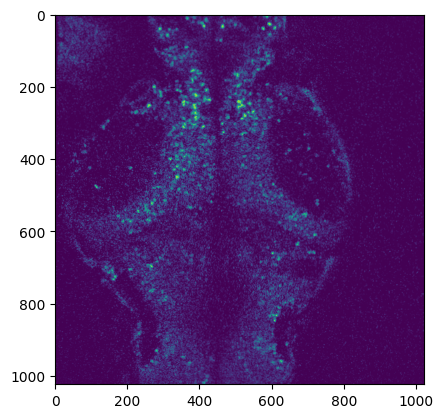

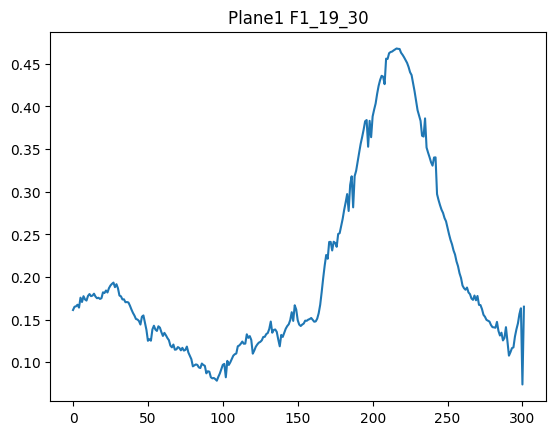

217
(0, 0)


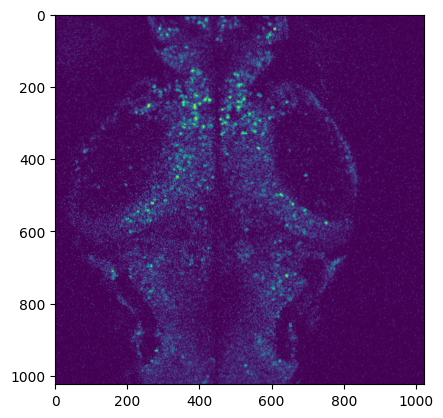

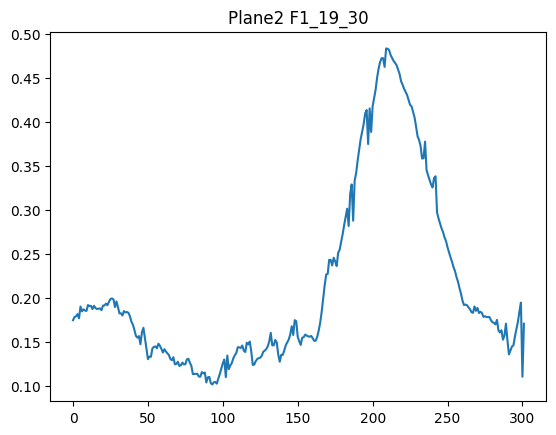

210
(0, 0)


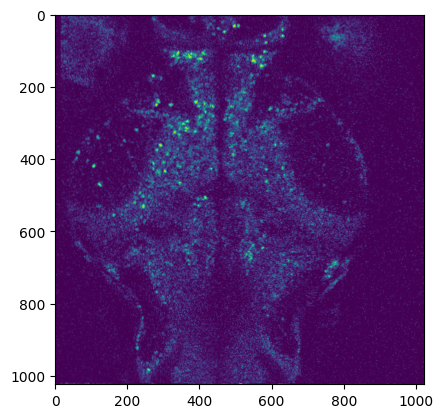

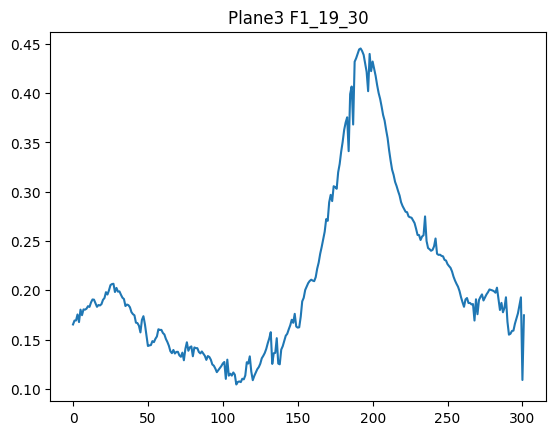

193
(0, 0)


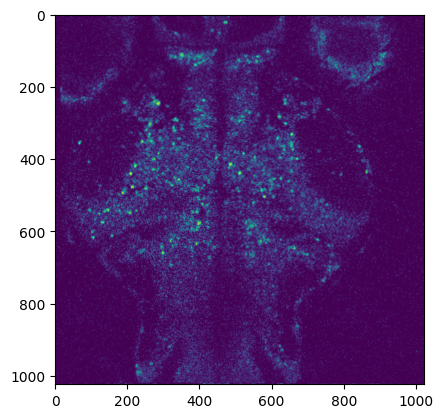

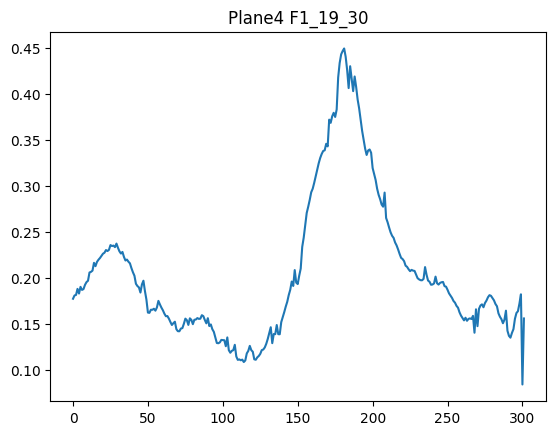

182
(0, 0)


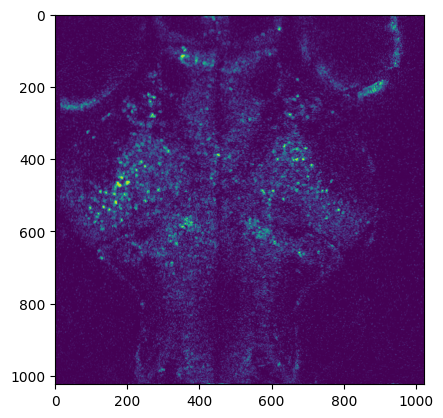

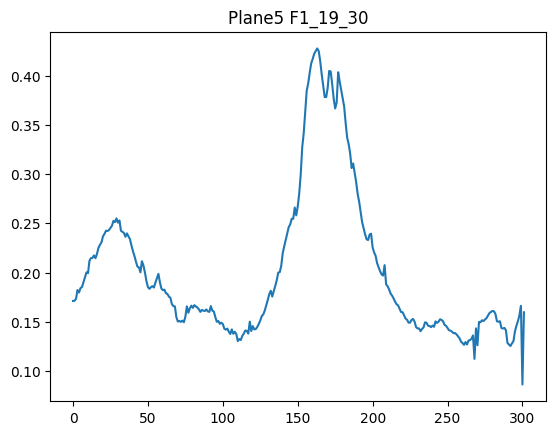

164
(0, 0)


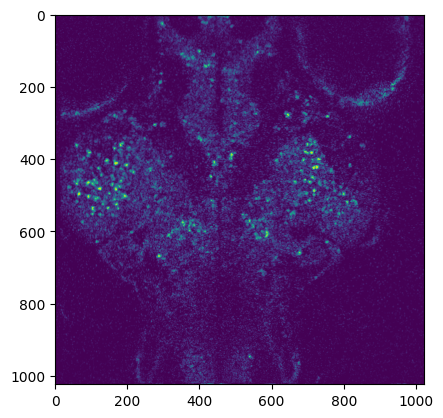

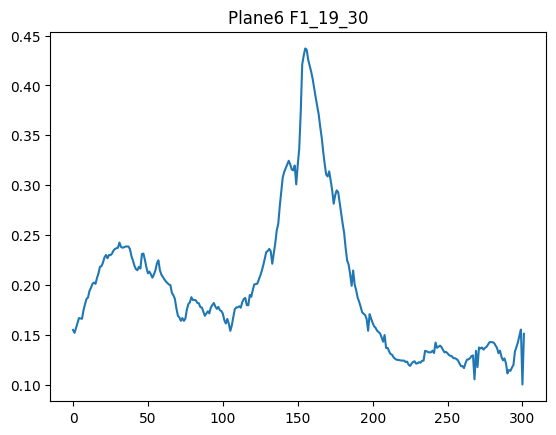

156
(0, 0)


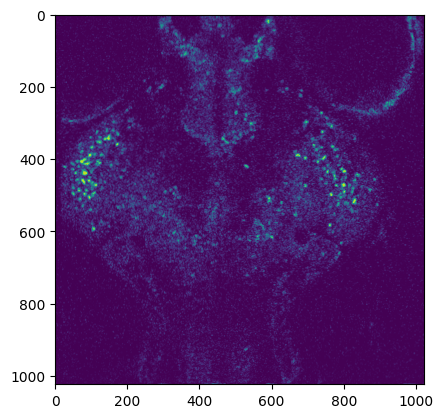

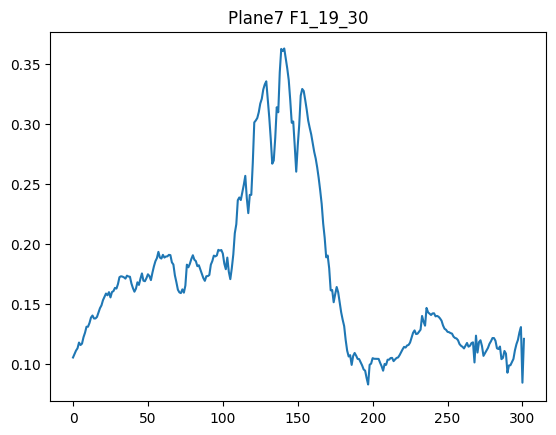

142
(0, 0)


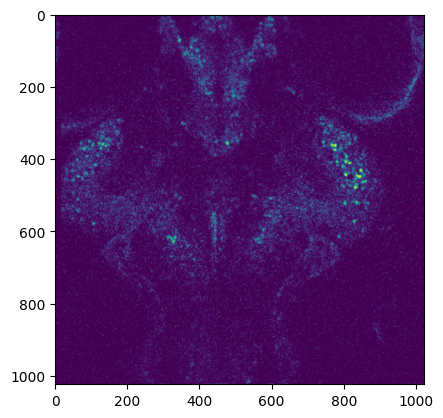

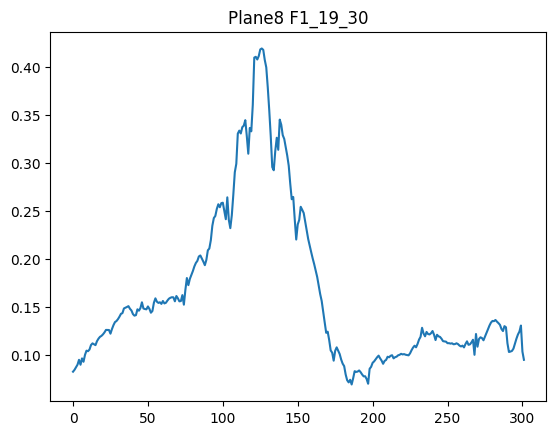

127
(0, 0)


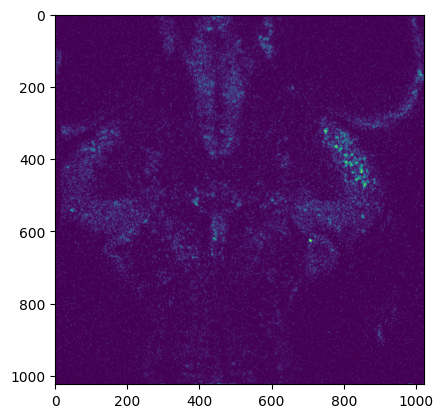

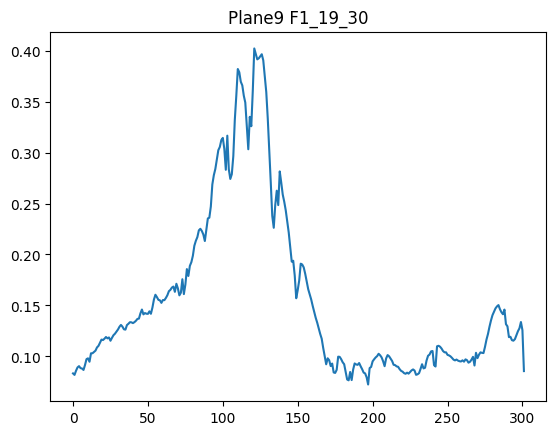

122
(0, 0)


In [35]:
zscan_tif_files = glob.glob(main_dir+'/*/*zscan.tif')
for fish in zscan_tif_files:
    
    fish_str = fish.split('/')[-1][:8]
    date_str = fish.split('/')[-2]
    processed_dir = main_dir +date_str+ '/processed/'+fish_str
    processed_suite2p_dir = processed_dir + '/processed_suite2p'
    
    for p_i in range(1,plane_no+1):
        directory_2d = processed_dir+'/registration/reg_2d/plane'+str(p_i)
        create_directory(directory_2d)
##########################
### Remember to check whether the reading issue is solved in ubuntu system
        registered_tif0_dir = processed_suite2p_dir+'/plane'+str(p_i)+'/plane0/reg_tif/file001200_chan0.tif'
        registered_tif0 =  tifffile.imread(registered_tif0_dir)
#         avg_combined_reg = np.mean(combined_reg,axis = 0)
        avg_combined_reg_8bit = cv.convertScaleAbs(registered_tif0, alpha=0.7)
##########################
        tifffile.imwrite(directory_2d+'/'+fish_str+'_'+'plane'+str(p_i)+'_avg_combined_reg.tif', avg_combined_reg_8bit)
        
        temp_image = Image.open(directory_2d+'/'+fish_str+'_'+'plane'+str(p_i)+'_avg_combined_reg.tif')
        resized_image = temp_image.resize((resize, resize), Image.Resampling.LANCZOS)
        resized_image.save(directory_2d+'/'+fish_str+'_'+'plane'+str(p_i)+'_avg_combined_reg_resized.tif')
        
        img2 = tifffile.imread(fish)
        template =  cv.imread(directory_2d+'/'+fish_str+'_'+'plane'+str(p_i)+'_avg_combined_reg_resized.tif',0)
        
        
        plt.imshow(template)
        plt.show()
        w, h = template.shape[::-1]
        method = cv.TM_CCOEFF_NORMED
        # top_left = np.array(shape=(img2.shape[0],2))
        corr_score= []
        top_left_list = []
        for i in range(0,img2.shape[0]):
            img = img2[i].copy()
            res = cv.matchTemplate(img,template,method)
            min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
            top_left = max_loc
            corr_score.append(max_val)
            top_left_list.append(top_left)

        plt.plot(corr_score)
        plt.title('Plane'+str(p_i)+' '+fish_str)
        plt.show()
        temp_slice_no = np.argmax(corr_score)
    #     temp_slice_no = np.argmax(corr_score[80:])+80
        print(temp_slice_no+1)
        print(top_left_list[temp_slice_no])
        tifffile.imwrite(directory_2d+'/'+fish_str+'_'+'plane'+str(p_i)+'_zstack_slice.tif',img2[temp_slice_no,:,:])
        np.save(directory_2d+'/slice_no.npy',np.array(temp_slice_no+1))


### Step 3.2+: If there are errors when checking the reference, then use the code below to correct manually

In [ ]:
# Input part 
fish = '/media/semmelhacklab/P2_YX/LCr_UV_HSA_Lum_Low/20230312/F6_20_00_zscan.tif'
p_i = 9 # plane No.
temp_slice_no = 156 # Correct reference z position slice No.(display in fiji,need to -1 when saving the image)

In [ ]:
fish_str = fish.split('/')[-1][:8]
date_str = fish.split('/')[-2]
processed_dir = main_dir +date_str+ '/processed/'+fish_str
processed_suite2p_dir = processed_dir + '/processed_suite2p'


directory_2d = processed_dir+'/registration/reg_2d/plane'+str(p_i)
create_directory(directory_2d)

##########################
### Remember to check whether the reading issue is solved in ubuntu system
registered_tif0_dir = processed_suite2p_dir+'/plane'+str(p_i)+'/plane0/reg_tif/file001000_chan0.tif'
registered_tif0 =  tifffile.imread(registered_tif0_dir)
#         avg_combined_reg = np.mean(combined_reg,axis = 0)
avg_combined_reg_8bit = cv.convertScaleAbs(registered_tif0, alpha=0.7)
##########################

tifffile.imwrite(directory_2d+'/'+fish_str+'_'+'plane'+str(p_i)+'_avg_combined_reg.tif', avg_combined_reg_8bit)

temp_image = Image.open(directory_2d+'/'+fish_str+'_'+'plane'+str(p_i)+'_avg_combined_reg.tif')
resized_image = temp_image.resize((resize, resize), Image.Resampling.LANCZOS)
resized_image.save(directory_2d+'/'+fish_str+'_'+'plane'+str(p_i)+'_avg_combined_reg_resized.tif')
temp_image.close()

img2 = tifffile.imread(fish)
template =  cv.imread(directory_2d+'/'+fish_str+'_'+'plane'+str(p_i)+'_avg_combined_reg_resized.tif',0)
plt.imshow(template)
plt.show()
w, h = template.shape[::-1]
method = cv.TM_CCOEFF_NORMED
# top_left = np.array(shape=(img2.shape[0],2))
corr_score= []
top_left_list = []
for i in range(0,img2.shape[0]):
    img = img2[i].copy()
    res = cv.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    top_left = max_loc
    corr_score.append(max_val)
    top_left_list.append(top_left)

plt.plot(corr_score)
plt.title('Plane'+str(p_i)+' '+fish_str)
plt.show()

print(temp_slice_no)
print(top_left_list[temp_slice_no-1])
tifffile.imwrite(directory_2d+'/'+fish_str+'_'+'plane'+str(p_i)+'_zstack_slice.tif',img2[temp_slice_no-1,:,:])
np.save(directory_2d+'/slice_no.npy',np.array(temp_slice_no))


## Step 3.3: 2d Registration

Test done in hpc(for reference when writing code):
```
command="antsRegistration"
# command="python --version"
os.system("gnome-terminal -e 'bash -c \""+command+";bash\"'") # if you want the terminal to stay open and be in a bash shell 
os.system("gnome-terminal -e 'bash -c \""+command+"; sleep 10\" '") #if you need a terminal to stay open for 10s
os.system("gnome-terminal -e 'bash -c \""+command+"\" '") # if you want to close the terminal
```

In [36]:
# Input Part
main_dir = "/media/semmelhacklab/P2_YX/test_2p/"
plane_no = 9

In [37]:
zscan_tif_files = glob.glob(main_dir+'/*/*zscan.tif')
for fish in zscan_tif_files:
    
    fish_str = fish.split('/')[-1][:8]
    date_str = fish.split('/')[-2]
    processed_dir = main_dir +date_str+ '/processed/'+fish_str
    
    for p_i in range(1,plane_no+1):
        directory_2d = processed_dir+'/registration/reg_2d/plane'+str(p_i)
        
        sh_reg2d_path = directory_2d+'/reg2d.sh'
        # write 2d registration shell script for each plane
        with open(sh_reg2d_path,'w') as f:
            s = 'directory_2d='+directory_2d+'\n'+\
                'fish='+fish_str+'\n'+\
                'plane=plane'+str(p_i)+'\n'+\
                'reference=${directory_2d}/${fish}_${plane}_zstack_slice.tif\n'+\
                'moving_file=${directory_2d}/${fish}_${plane}_avg_combined_reg_resized.tif\n'+\
                'prefix=${directory_2d}/${fish}_${plane}_2d_output_\n'+\
                'warped_file=${prefix}warped.tif\n\n\n'+\
                'antsRegistration --verbose 1 \\\n\
                --dimensionality 2 \\\n\
                --float \\\n\
                --collapse-output-transforms 1 \\\n\
                --output [$prefix,${prefix}Warped.nii.gz,${prefix}InverseWarped.nii.gz ] \\\n\
                --interpolation Linear \\\n\
                --winsorize-image-intensities [ 0.005,0.995 ] \\\n\
                --initial-moving-transform [ $reference,$moving_file,1 ] \\\n\
                --transform Rigid[ 0.1 ] \\\n\
                --metric MI[ $reference,$moving_file,1,32,Regular,0.25 ] \\\n\
                --convergence [ 1000x500x250x0,1e-8,15 ] \\\n\
                --shrink-factors 12x8x4x2 \\\n\
                --smoothing-sigmas 4x3x2x1vox \\\n\
                --transform Affine[ 0.1 ] \\\n\
                --metric MI[ $reference,$moving_file,1,32,Regular,0.25 ] \\\n\
                --convergence [ 1000x500x250x0,1e-8,15 ] \\\n\
                --shrink-factors 12x8x4x2 \\\n\
                --smoothing-sigmas 4x3x2x1vox\n\n\n'+\
                'antsApplyTransforms --verbose 1 \\\n\
                --dimensionality 2 \\\n\
                --float \\\n\
                --interpolation WelchWindowedSinc \\\n\
                --input $moving_file \\\n\
                --reference-image $reference \\\n\
                --output $warped_file \\\n\
                --transform ${prefix}0GenericAffine.mat'
            f.write(s)

        # run the shell script above
        command="sh "+sh_reg2d_path
        os.system("gnome-terminal -e 'bash -c \""+command+"; sleep 5\" '")
        time.sleep(10)

# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line t

## Step 3.4: 3d Registration(takes around 0.5hr per fish)

In [27]:
# Input Part
main_dir = "/media/semmelhacklab/P2_YX/test_2p/"
reference_path = "/media/semmelhacklab/P2_YX/registration_code_HSA/T_AVG_H2BGCaMP.nrrd"

In [28]:
zscan_tif_files = glob.glob(main_dir+'/*/*zscan.tif')
for fish in zscan_tif_files:
    
    fish_str = fish.split('/')[-1][:8]
    date_str = fish.split('/')[-2]
    processed_dir = main_dir +date_str+ '/processed/'+fish_str
    directory_3d = processed_dir+'/registration/reg_3d'
    
    sh_reg3d_path = directory_3d+'/reg3d.sh'

    # write 3d registration shell script for each fish
    with open(sh_reg3d_path,'w') as f:
        s = 'reference='+reference_path+'\n'+\
            'directory_3d='+directory_3d+'\n'+\
            'fish='+fish_str+'\n'+\
            'moving_file=${directory_3d}/${fish}_zscan.nrrd\n'+\
            'prefix=${directory_3d}/${fish}_reg3d_\n'+\
            'warped_file=${prefix}zscan_wrapped.nrrd\n\n\n'+\
            'antsRegistration --verbose 1 \\\n\
            --dimensionality 3 \\\n\
            --float \\\n\
            --collapse-output-transforms 1 \\\n\
            --output [$prefix,${prefix}Warped.nii.gz,${prefix}InverseWarped.nii.gz ] \\\n\
            --interpolation Linear \\\n\
            --winsorize-image-intensities [ 0.005,0.995 ] \\\n\
            --initial-moving-transform [ $reference,$moving_file,1 ] \\\n\
            --transform Rigid[ 0.1 ] \\\n\
            --metric MI[ $reference,$moving_file,1,32,Regular,0.25 ] \\\n\
            --convergence [ 1000x500x250x0,1e-6,10 ] \\\n\
            --shrink-factors 12x8x4x2 \\\n\
            --smoothing-sigmas 4x3x2x1vox \\\n\
            --transform Affine[ 0.1 ] \\\n\
            --metric MI[ $reference,$moving_file,1,32,Regular,0.25 ] \\\n\
            --convergence [ 1000x500x250x0,1e-6,10 ] \\\n\
            --shrink-factors 12x8x4x2 \\\n\
            --smoothing-sigmas 4x3x2x1vox \\\n\
            --transform SyN[ 0.1,3,0 ] \\\n\
            --metric MI[ $reference,$moving_file,1,32] \\\n\
            --convergence [ 100x100x70x50x0,1e-6,10 ] \\\n\
            --shrink-factors 10x6x4x2x1 \\\n\
            --smoothing-sigmas 5x3x2x1x0vox\n\n\n'+\
            'antsApplyTransforms --verbose 1 \\\n\
            --dimensionality 3 \\\n\
            --float \\\n\
            --interpolation WelchWindowedSinc \\\n\
            --input $moving_file \\\n\
            --reference-image $reference \\\n\
            --output $warped_file \\\n\
            --transform ${prefix}1Warp.nii.gz \\\n\
            --transform ${prefix}0GenericAffine.mat'
        f.write(s)
        
    # run the shell script above
    command="sh "+sh_reg3d_path
    os.system("gnome-terminal -e 'bash -c \""+command+"; sleep 30\" '")
    time.sleep(1500)

# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.


## Step 3.5: (No code but Important!!!) Check the registration performance of warped file One By One

# Step 4: Apply transformation files on all the segmented neurons

In [45]:
# Input part
main_dir = "/media/semmelhacklab/P2_YX/test_2p/"

##########################
### Rember to check whether resize or not work better
resize_ratio = 1024/512
##########################

## Step 4.1: organize the coordinates of the segmented neurons from each plane and save in reg2d folder

In [46]:
zscan_tif_files = glob.glob(main_dir+'/*/*zscan.tif')
for fish in zscan_tif_files:
    fish_str = fish.split('/')[-1][:8]
    date_str = fish.split('/')[-2]
    processed_dir = main_dir +date_str+ '/processed/'+fish_str
    processed_suite2p_dir = processed_dir + '/processed_suite2p'
    
    for p_i in range(1,plane_no+1):
        directory_2d = processed_dir+'/registration/reg_2d/plane'+str(p_i)
        slice_no = np.load(directory_2d+'/slice_no.npy')
        path_cell_info = processed_suite2p_dir+'/plane'+str(p_i)+'/DeltaF_F/cell_info_'+fish_str+'_plane'+str(p_i)+'.csv'
        df_cell_info = pd.read_csv(path_cell_info)
        
        df_coor = pd.DataFrame(columns = ['x','y','z','t','label'])
        df_coor.x = df_cell_info.centroid_x*resize_ratio
        df_coor.y = df_cell_info.centroid_y*resize_ratio
        df_coor.z = slice_no
        df_coor.t = 0
        df_coor.label = df_cell_info.ROI_id
        
        path_toreg = directory_2d+'/'+fish_str+'_plane'+str(p_i)+'_coordinates.csv'
        df_coor.to_csv(path_toreg,index=False)   

## Step 4.2: Apply reg2d transformation

In [47]:
zscan_tif_files = glob.glob(main_dir+'/*/*zscan.tif')
for fish in zscan_tif_files:
    
    fish_str = fish.split('/')[-1][:8]
    date_str = fish.split('/')[-2]
    processed_dir = main_dir +date_str+ '/processed/'+fish_str
    
    for p_i in range(1,plane_no+1):
        directory_2d = processed_dir+'/registration/reg_2d/plane'+str(p_i)
        
        sh_applyreg2d_path = directory_2d+'/ApplyToROIs_reg2d.sh'
        # write 2d ApplyToROIs shell script for each plane
        with open(sh_applyreg2d_path,'w') as f:
            s = 'directory_2d='+directory_2d+'\n'+\
                'fish='+fish_str+'\n'+\
                'plane=plane'+str(p_i)+'\n'+\
                'prefix2d=${directory_2d}/${fish}_${plane}_2d_output_\n'+\
                'prefix_csv=${directory_2d}/${fish}_${plane}_coordinates\n\n\n'+\
                'antsApplyTransformsToPoints -d 2 -i ${prefix_csv}.csv -o ${prefix_csv}_reg2d.csv -t [${prefix2d}0GenericAffine.mat,1]'
            f.write(s)

        # run the shell script above
        command="sh "+sh_applyreg2d_path
        os.system("gnome-terminal -e 'bash -c \""+command+"; sleep 3\" '")
        time.sleep(3)

# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line t

## Step 4.3: Transform the unit of the registered 2d coordinates as microns

In [48]:
# Input part
ratio_pixel_to_micron = 509.12/1024

In [49]:
dir_list = glob.glob(main_dir+'/*/processed/*/registration/reg_2d/*/F*_reg2d.csv')

for temp_dir in dir_list:
    temp_reg2d_csv = pd.read_csv(temp_dir)
    temp_reg2d_csv.x = temp_reg2d_csv.x*ratio_pixel_to_micron
    temp_reg2d_csv.y = temp_reg2d_csv.y*ratio_pixel_to_micron
    temp_reg2d_csv.to_csv(temp_dir[:-4]+'_micron.csv',index=False)

## Step 4.4: Apply reg3d transformation

In [58]:
zscan_tif_files = glob.glob(main_dir+'/*/*zscan.tif')
for fish in zscan_tif_files:
    
    fish_str = fish.split('/')[-1][:8]
    date_str = fish.split('/')[-2]
    processed_dir = main_dir +date_str+ '/processed/'+fish_str
    directory_3d = processed_dir+'/registration/reg_3d'
    
    for p_i in range(1,plane_no+1):
        directory_2d = processed_dir+'/registration/reg_2d/plane'+str(p_i)
        sh_applyreg3d_path = directory_2d+'/ApplyToROIs_reg3d.sh'

        # write 3d ApplyToROIs shell script for each fish
        with open(sh_applyreg3d_path,'w') as f:
            s = 'directory_3d='+directory_3d+'\n'+\
                'directory_2d='+directory_2d+'\n'+\
                'fish='+fish_str+'\n'+\
                'plane=plane'+str(p_i)+'\n'+\
                'prefix3d=${directory_3d}/${fish}_reg3d_\n'+\
                'prefix_csv=${directory_2d}/${fish}_${plane}_coordinates\n\n\n'+\
                'antsApplyTransformsToPoints -d 3 -i ${prefix_csv}_reg2d_micron.csv -o ${prefix_csv}_reg3d.csv -t [${prefix3d}0GenericAffine.mat,1] -t ${prefix3d}1InverseWarp.nii.gz'
            f.write(s)

        # run the shell script above
        command="sh "+sh_applyreg3d_path
        os.system("gnome-terminal -e 'bash -c \""+command+"; sleep 3\" '")
        time.sleep(20)

# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line to execute after it.
# Option “-e” is deprecated and might be removed in a later version of gnome-terminal.
# Use “-- ” to terminate the options and put the command line t

## Step 4.5: Save the registered coordinate information back into cell_info csv

In [61]:
zscan_tif_files = glob.glob(main_dir+'/*/*zscan.tif')
for fish in zscan_tif_files:
    fish_str = fish.split('/')[-1][:8]
    date_str = fish.split('/')[-2]
    processed_dir = main_dir +date_str+ '/processed/'+fish_str
    processed_suite2p_dir = processed_dir + '/processed_suite2p'
    
    for p_i in range(1,plane_no+1):
        path_csv_reg3d = processed_dir+'/registration/reg_2d/plane'+str(p_i)+'/'+fish_str+'_plane'+str(p_i)+'_coordinates_reg3d.csv'
        df_csv_reg3d = pd.read_csv(path_csv_reg3d)
        
        path_cell_info = processed_suite2p_dir+'/plane'+str(p_i)+'/DeltaF_F/cell_info_'+fish_str+'_plane'+str(p_i)+'.csv'
        df_cell_info = pd.read_csv(path_cell_info)
        
        if np.array_equiv(np.array(df_cell_info['ROI_id']),np.array(df_csv_reg3d['label'])):
            df_cell_info['reg_x'] = df_csv_reg3d['x']
            df_cell_info['reg_y'] = df_csv_reg3d['y']
            df_cell_info['reg_z'] = df_csv_reg3d['z']
            df_cell_info.to_csv(path_cell_info[:-4index = False)
        else:
            print('error when writing '+path_csv_reg3d)

## Step 4.6 (No Code but important!!!) Check the registration performance by examining registered position of landmark cells